In [362]:
import os
import json
from neo4j import GraphDatabase
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import glob
from matplotlib.colors import ListedColormap
import numpy as np

In [363]:
base_dir = '/Users/janamian/Documents/workstation/ucsd_dse_program/fall_2019/docker_vol/saba-ja/workstation/dse_203_2020/project/dse_203_final_project_fall_2020/data'

In [364]:
nvdcve_files = sorted(glob.glob(os.path.join(base_dir, 'nvd_data','nvdcve-1.1*.json')), reverse=True)

In [365]:
for val in nvdcve_files:
    print(val.split('/')[-1])

nvdcve-1.1-2020.json
nvdcve-1.1-2019.json
nvdcve-1.1-2018.json
nvdcve-1.1-2017.json
nvdcve-1.1-2016.json
nvdcve-1.1-2015.json
nvdcve-1.1-2014.json
nvdcve-1.1-2013.json
nvdcve-1.1-2012.json
nvdcve-1.1-2011.json
nvdcve-1.1-2010.json
nvdcve-1.1-2009.json
nvdcve-1.1-2008.json
nvdcve-1.1-2007.json
nvdcve-1.1-2006.json
nvdcve-1.1-2005.json
nvdcve-1.1-2004.json
nvdcve-1.1-2003.json
nvdcve-1.1-2002.json


In [366]:
# #############
# Read all CWE data
# Read all NVD CVE Json files
# #############
with open(os.path.join(base_dir, 'cwe_data', 'cwec_v4.2.json')) as f:
    cwe = json.load(f)
    
nvd_list = []
for file_addr in nvdcve_files:
    with open(file_addr) as f:
        nvd_list.append(json.load(f))

In [367]:
def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""

    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)

    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept

    #Plot trendline
    plt.plot(xl, yl, c, alpha=alpha, linestyle='--')

    #Calculate R Squared
    p = np.poly1d(coeffs)

    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot

    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.65 * np.max(yd) + 0.4 * np.min(yd),
                 f'R^2 = {Rsqr:0.2f}\nm = {slope:0.0f}')
    else:
        #Return the R^2 value:
        return Rsqr

In [368]:
def get_related_cwe(data_list):
    # CVE object
    resultw = []
    if not isinstance(data_list['problemtype']['problemtype_data'], list):
        print(data_list['problemtype']['problemtype_data'])
        raise ValueError
        
    if len(data_list['problemtype']['problemtype_data']) != 1:
        print(data_list['problemtype']['problemtype_data'])
        raise ValueError
        
    for val in data_list['problemtype']['problemtype_data'][0]['description']:
        resultw.append(val['value'])
    return resultw

def get_reference_url(data_list):
    result = []
    for val in data_list['references']['reference_data']:
        result.append(val['url'])
    return result

def get_tags(data_list):
    result = []
    for val in data_list['references']['reference_data']:
        for val2 in val['tags']:
            result.append(val2)

    return result

def get_description_data(data_list):
    result = []
    for val in data_list['description']['description_data']:
        if val['lang'] == 'en':
            result.append(val['value'])
    return result

def get_cpe_match(cpe_match_list):
    result = []
    try:
        for val in cpe_match_list['cpe_match']:
            result.append(val['cpe23Uri'])
    except KeyError:
        pass
    return result

def get_impacted_configuration(data_list):
    result = []
    for val in data_list['nodes']:

        result.extend(get_cpe_match(val))
        
        if 'children' in val.keys():
            for val2 in val['children']:
                result.extend(get_cpe_match(val2))

    return result

cve_clean_result = []
total_cwes = 0
total_cves = 0
for nvd_obj in nvd_list:
    for cve_obj in nvd_obj['CVE_Items']:
        published_date = cve_obj['publishedDate']
        yy = published_date.split('-')[0]
        if int(yy) < 2000:
            continue
            
        modified_date = cve_obj['lastModifiedDate']
        
        cve_id = cve_obj['cve']['CVE_data_meta']['ID']
        total_cves += 1
        
        related_cwe_list = get_related_cwe(cve_obj['cve'])
        if len(related_cwe_list) == 0:
            related_cwe_list = ['NVD-no-analysis']
            total_cwes += 1
#             print(cve_id)
        else:
            total_cwes += len(related_cwe_list)
        
        description = get_description_data(cve_obj['cve'])
        reference_url = get_reference_url(cve_obj['cve'])
        tags = get_tags(cve_obj['cve'])
        
        try:
            cvss_base_score = cve_obj['impact']['baseMetricV3']['cvssV3']['baseScore']
            cvss_base_severity = cve_obj['impact']['baseMetricV3']['cvssV3']['baseSeverity']
        except KeyError:
            cvss_base_score = 'unknown'
            cvss_base_severity = 'unknown'

        impacted_config = get_impacted_configuration(cve_obj['configurations'])
        
        cve_clean_result.append({
            'cve_id': cve_id,
            'related_cwe_list':related_cwe_list,
            'description': description,
            'reference_url':reference_url,
            'tags':tags,
            'cvss_base_score': cvss_base_score,
            'cvss_base_severity':cvss_base_severity,
            'impacted_config': impacted_config,
            'published_date': published_date,
            'modified_date': modified_date
         })

In [369]:
counter = {}
for val in cve_clean_result:
    year = val['published_date'].split('-')[0]
    c = counter.get(year, 0)
    c += 1
    counter[year] = c
    
data = {'year':[], 'count':[]}
for key, value in counter.items():
    data['year'].append(int(key))
    data['count'].append(value)
    
cve_count_df = pd.DataFrame(data)
cve_count_df.sort_values(by=['year'], ascending=True, inplace=True)
cve_count_df.rename(columns={'count':'number_of_reported_cve'}, inplace=True)
cve_count_df.set_index('year', drop=True, inplace=True)

In [370]:
cve_count_df

,number_of_reported_cve
year,
2000,1020
2001,1679
2002,2170
2003,1548
2004,2479
2005,5010
2006,6659
2007,6596
2008,5664


152178


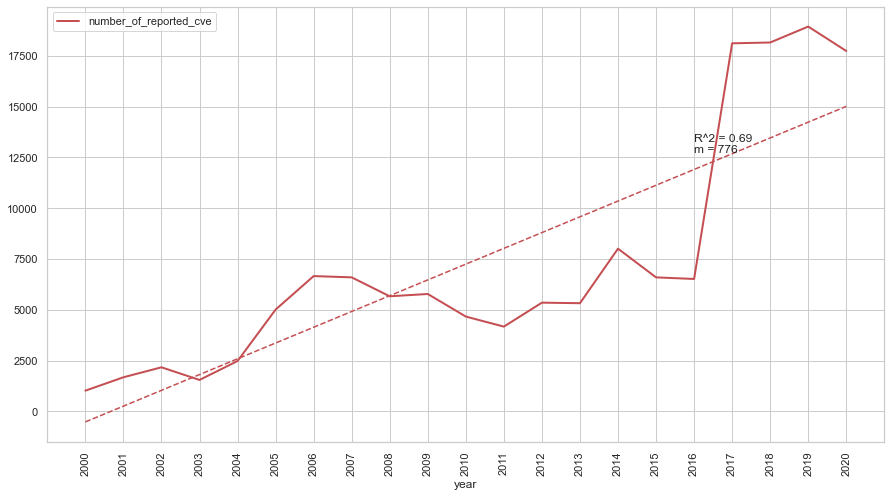

In [371]:
print(cve_count_df['number_of_reported_cve'].sum())
cve_count_df.plot(kind='line', color='r',figsize=(15,8), linewidth=2)
plt.xticks(cve_count_df.index,rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
trendline(list(cve_count_df.index), list(cve_count_df['number_of_reported_cve']), c='r')

In [372]:
cve_count_df.index

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='year')

In [373]:
print('Total CVEs: ', len(cve_clean_result))
print('Total CWEs in CVEs: ', total_cwes)

Total CVEs:  152178
Total CWEs in CVEs:  154169


In [374]:
# #############
# Count CWEs causing CVE
# #############

cwe_count = {}
for val in cve_clean_result:
    for cwe in val['related_cwe_list']:
        cwe_c = cwe_count.get(cwe, 0)
        cwe_c += 1
        cwe_count[cwe] = cwe_c

In [375]:
data = {'cwe_id':[], 'count':[]}
for key, value in cwe_count.items():
    data['cwe_id'].append(f'{key}')
    data['count'].append(value)
    
cwe_count_df = pd.DataFrame(data)
cwe_count_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_count_df.reset_index(drop=True, inplace=True)
cwe_count_filtered_gt_n = cwe_count_df[cwe_count_df['count'] >= 250]

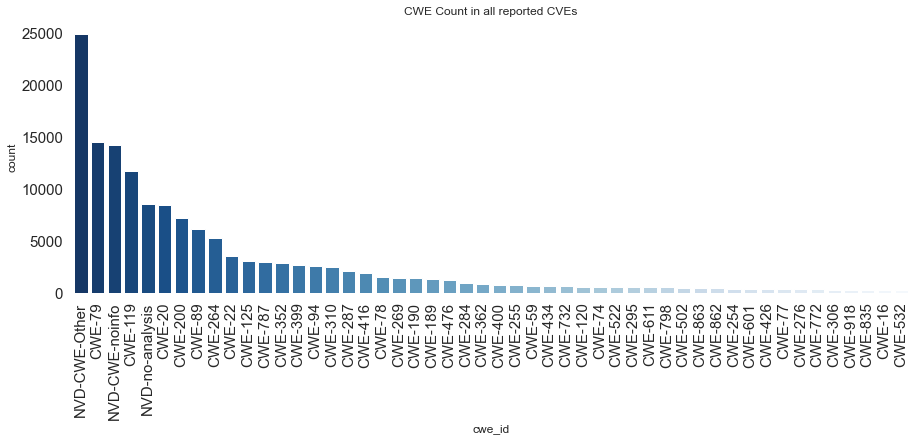

In [376]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="cwe_id", y="count", palette="Blues_r", data=cwe_count_filtered_gt_n, ci=None);
plt.title('CWE Count in all reported CVEs')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

In [377]:
less_than_n_cwe = cwe_count_df[cwe_count_df['count'] < 5000]['count'].sum()

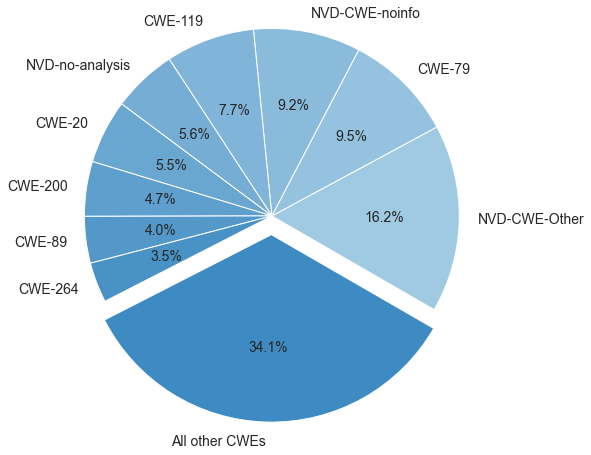

In [378]:
labels = list(cwe_count_df[cwe_count_df['count'] >= 5000]['cwe_id'])
labels.append('All other CWEs')
sizes = list(cwe_count_df[cwe_count_df['count'] >= 5000]['count'])
sizes.append(less_than_n_cwe)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes,
        explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1),
        labels=labels, 
        autopct='%1.1f%%',
        shadow=False, 
        startangle=-30, 
        textprops={'fontsize': 14}, 
        colors=sns.color_palette("Blues_d", 20))

ax1.axis('equal')

plt.show()

In [379]:
sum(sizes)

154169

In [380]:

column_names = []
column_names.extend(labels)
cve_to_cwe_per_year_df = pd.DataFrame(columns=column_names, index=list(range(1988,2021)))
cve_to_cwe_per_year_df.fillna(0, inplace=True)
for val in cve_clean_result:
    year_val = int(val['published_date'].split('-')[0])
    for cwe in val['related_cwe_list']:
        if cwe in column_names:
            cwe_count = cve_to_cwe_per_year_df.loc[year_val, cwe]
            cve_to_cwe_per_year_df.loc[year_val, cwe] = cwe_count + 1
        else:
            cwe_count = cve_to_cwe_per_year_df.loc[year_val, 'All other CWEs']
            cve_to_cwe_per_year_df.loc[year_val, 'All other CWEs'] = cwe_count + 1
            
cve_to_cwe_per_year_df.rename(columns={
'CWE-79' : '(CWE-79 ) Cross-site Scripting',
'CWE-119': '(CWE-119) Buffer Overflow',
'CWE-20' : '(CWE-20 ) Improper Input validation',
'CWE-200': '(CWE-200) Exposure of Info',
'CWE-89' : '(CWE-89 ) SQL Injection',
'CWE-264': '(CWE-264) Permission Control'}, inplace=True)

In [381]:
df_temp1 = cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000][['NVD-CWE-Other', 'NVD-CWE-noinfo', 'NVD-no-analysis']]

line_data = df_temp1.sum(axis=1)
line_data_df_1 = line_data.to_frame().reset_index(drop=False)
line_data_df_1.rename(columns={'index':'year', 0:'NVD-CWE-Other'}, inplace=True)
line_data_df_1.astype(int)
line_data_df_1.set_index('year', drop=True, inplace=True)
NVD_CWE_Other_only = line_data_df_1

In [382]:
df_temp2 = cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000].drop(['All other CWEs'], axis=1)
line_data = df_temp2.sum(axis=1)
line_data_df_2 = line_data.to_frame().reset_index(drop=False)
line_data_df_2.rename(columns={'index':'year', 0:'cwe_count'}, inplace=True)
line_data_df_2.astype(int)
line_data_df_2.set_index('year', drop=True, inplace=True)
majro_cwe_each_year = line_data_df_2

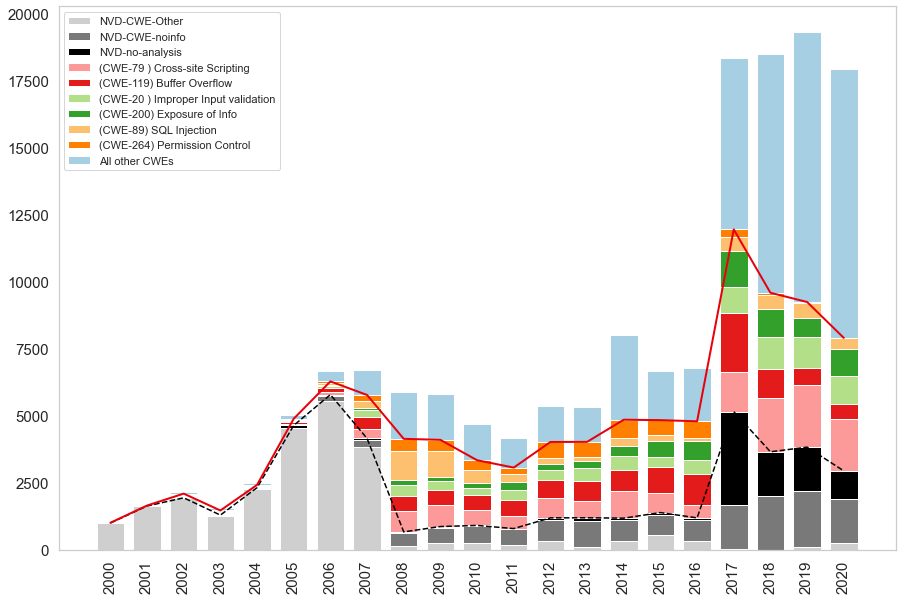

In [383]:
width=0.75
filtered_years = cve_to_cwe_per_year_df[cve_to_cwe_per_year_df.index >= 2000]
fig, ax = plt.subplots(figsize=(15,10))
years = list(filtered_years.index)

nvd_1 = filtered_years['NVD-CWE-Other']
nvd_2 = filtered_years['NVD-CWE-noinfo']
nvd_3 = filtered_years['NVD-no-analysis']

cwe_79 = filtered_years['(CWE-79 ) Cross-site Scripting']
cwe_119 = filtered_years['(CWE-119) Buffer Overflow']
cwe_20 = filtered_years['(CWE-20 ) Improper Input validation']
cwe_200 = filtered_years['(CWE-200) Exposure of Info']
cwe_89 = filtered_years['(CWE-89 ) SQL Injection']
cwe_264 = filtered_years['(CWE-264) Permission Control']
all_other_cwe = filtered_years['All other CWEs']

ax.bar(years, nvd_1, width, label='NVD-CWE-Other', color='#CFCFCF') # '#B4D47B'
ax.bar(years, nvd_2, width, bottom=sum([nvd_1]), label='NVD-CWE-noinfo', color='#797979')
ax.bar(years, nvd_3, width, bottom=sum([nvd_1, nvd_2]), label='NVD-no-analysis', color='#000000')

ax.bar(years, cwe_79, width, bottom=sum([nvd_1, nvd_2, nvd_3]), label='(CWE-79 ) Cross-site Scripting', color='#FB9A99')
ax.bar(years, cwe_119, width, bottom=sum([nvd_1, nvd_2, nvd_3, cwe_79]), label='(CWE-119) Buffer Overflow', color='#E31B1B')
ax.bar(years, cwe_20, width, bottom=sum([nvd_1, nvd_2, nvd_3, cwe_79, cwe_119]), label='(CWE-20 ) Improper Input validation', color='#B3DF89')
ax.bar(years, cwe_200, width, bottom=sum([nvd_1, nvd_2, nvd_3, cwe_79, cwe_119, cwe_20]), label='(CWE-200) Exposure of Info', color='#33A02C')
ax.bar(years, cwe_89, width, bottom=sum([nvd_1, nvd_2, nvd_3, cwe_79, cwe_119, cwe_20, cwe_200]), label='(CWE-89) SQL Injection', color='#FCC06F')
ax.bar(years, cwe_264, width, bottom=sum([nvd_1, nvd_2, nvd_3, cwe_79, cwe_119, cwe_20, cwe_200, cwe_89]), label='(CWE-264) Permission Control', color='#FF7F01')
ax.bar(years, all_other_cwe, width, bottom=sum([nvd_1, nvd_2, nvd_3, cwe_79, cwe_119, cwe_20, cwe_200, cwe_89, cwe_264]), label='All other CWEs', color='#A6CFE3')

ax.plot(years, NVD_CWE_Other_only, color='#000000', linestyle='--')
ax.plot(years, majro_cwe_each_year, color='#E8000B', linewidth=2)
ax.legend()
plt.xticks(years,rotation=90);
plt.grid(False)
# plt.box(on=None)

In [384]:
# #############
# Count CWEs causing CVE in 2017 and after only
# #############
def count_the_cwes(years):
    cwe_count = {}
    for val in cve_clean_result:
        year = val['published_date'].split('-')[0]
        if year not in years:
            continue
        for cwe in val['related_cwe_list']:
            cwe_c = cwe_count.get(cwe, 0)
            cwe_c += 1
            cwe_count[cwe] = cwe_c
    return cwe_count

In [385]:
# #############
# CWEs color constants
# #############
NVDCWEOther_COLOR = '#CFCFCF'
NVDCWEnoinfo_COLOR = '#797979'
NVDnoanalysis_COLOR = '#000000'

In [386]:
data = {'cwe_id':[], 'count':[]}
for key, value in count_the_cwes(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007']).items():
    data['cwe_id'].append(f'{key}')
    data['count'].append(value)
    
cwe_count_df = pd.DataFrame(data)
cwe_count_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_count_df.reset_index(drop=True, inplace=True)
cwe_count_filtered_gt_n = cwe_count_df[cwe_count_df['count'] >= 200]

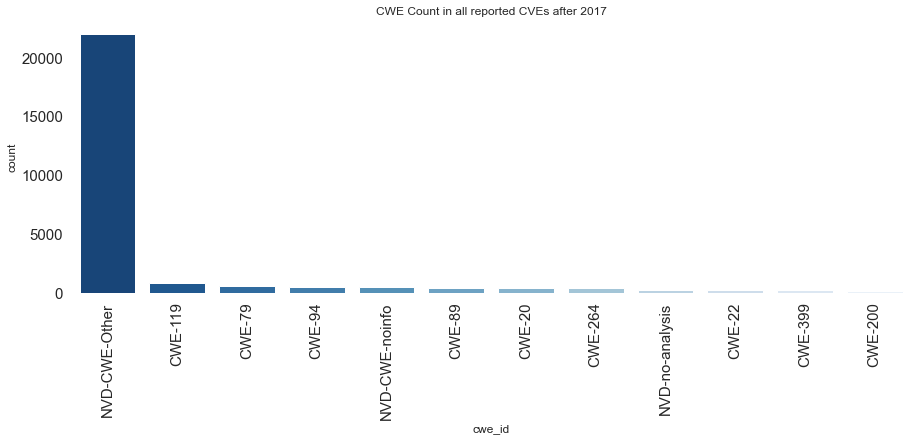

In [387]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="cwe_id", y="count", palette="Blues_r", data=cwe_count_filtered_gt_n, ci=None);
plt.title('CWE Count in all reported CVEs after 2017')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

In [388]:
len(sizes)

10

In [389]:
def graph_cwe_count_chart(limit, angle, colors=sns.color_palette("Blues_d", 20)):
    less_than_n_cwe = cwe_count_df[cwe_count_df['count'] < limit]['count'].sum()
    labels = list(cwe_count_df[cwe_count_df['count'] >= limit]['cwe_id'])
    labels.append('All other CWEs')
    sizes = list(cwe_count_df[cwe_count_df['count'] >= limit]['count'])
    sizes.append(less_than_n_cwe)
    fig1, ax1 = plt.subplots(figsize=(8,8))
    ax1.pie(sizes,
    #         explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1),
            labels=labels, 
            autopct='%1.1f%%',
            shadow=False, 
            startangle=angle, 
            textprops={'fontsize': 14}, 
            colors=colors)

    ax1.axis('equal')

    plt.show()

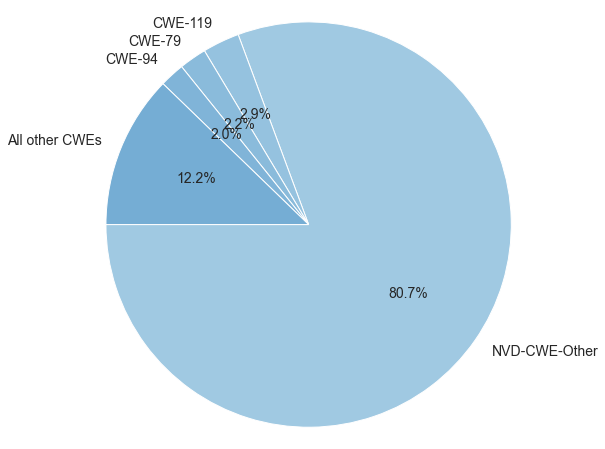

In [390]:
graph_cwe_count_chart(500, -180)

In [391]:
data = {'cwe_id':[], 'count':[]}
for key, value in count_the_cwes(['2008', '2009', '2010', '2011', '2012','2013', '2014', '2015', '2016']).items():
    data['cwe_id'].append(f'{key}')
    data['count'].append(value)
    
cwe_count_df = pd.DataFrame(data)
cwe_count_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_count_df.reset_index(drop=True, inplace=True)
cwe_count_filtered_gt_n = cwe_count_df[cwe_count_df['count'] >= 200]

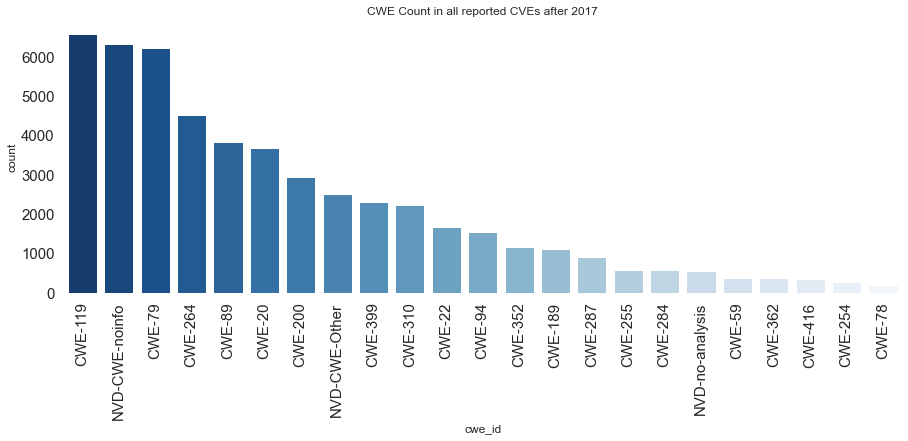

In [392]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="cwe_id", y="count", palette="Blues_r", data=cwe_count_filtered_gt_n, ci=None);
plt.title('CWE Count in all reported CVEs after 2017')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

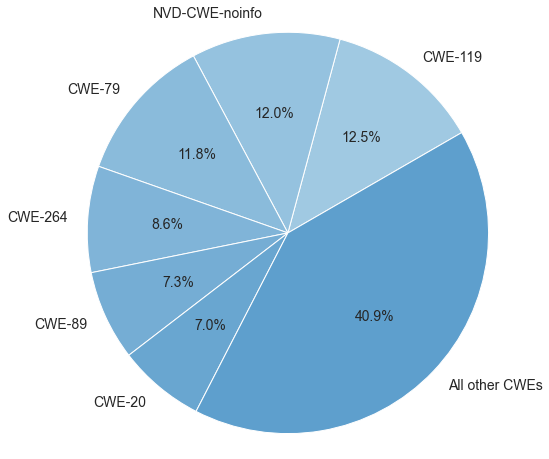

In [393]:
graph_cwe_count_chart(3000, 30)

In [394]:
data = {'cwe_id':[], 'count':[]}
for key, value in count_the_cwes(['2016', '2017', '2018', '2019','2020']).items():
    data['cwe_id'].append(f'{key}')
    data['count'].append(value)
    
cwe_count_df = pd.DataFrame(data)
cwe_count_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_count_df.reset_index(drop=True, inplace=True)
cwe_count_filtered_gt_n = cwe_count_df[cwe_count_df['count'] >= 200]

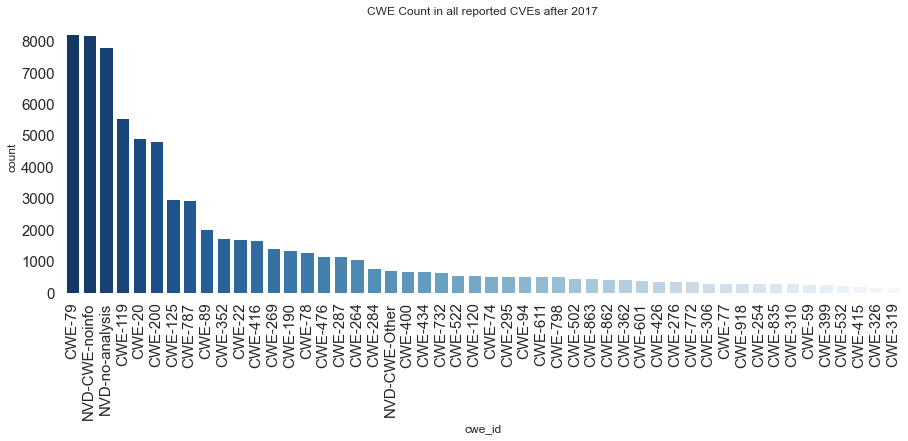

In [395]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="cwe_id", y="count", palette="Blues_r", data=cwe_count_filtered_gt_n, ci=None);
plt.title('CWE Count in all reported CVEs after 2017')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

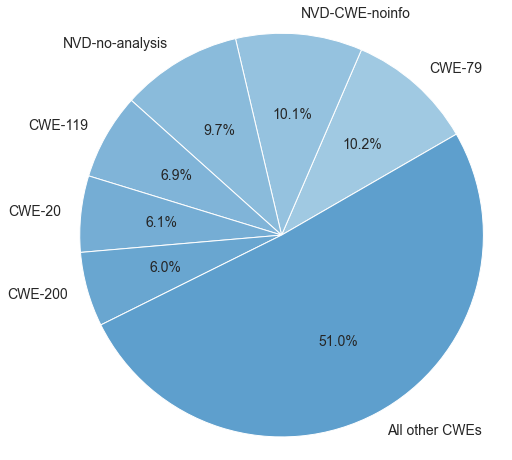

In [396]:
graph_cwe_count_chart(3000, 30)

In [397]:
# #############
# Companies reporting CVEs
# #############
company_counter = {}
product_counter = {}
company_impact_severity = {}
company_product_counter = {}

for val in cve_clean_result:
    impacted_cpe_list = val['impacted_config']
    impact_severity = val['cvss_base_severity']
    for val2 in impacted_cpe_list:
        company = val2.split(':')[3]
        product = val2.split(':')[4]
        company_product = f'{company}:{product}'

        c = company_counter.get(company, 0)
        c += 1
        company_counter[company] = c
        
        c = product_counter.get(product, 0)
        c += 1
        product_counter[product] = c
        
        c = company_product_counter.get(company_product, 0)
        c += 1
        company_product_counter[company_product] = c
        
        c_obj = company_impact_severity.get(company, {'LOW':0, 'MEDIUM':0, 'HIGH':0, 'CRITICAL':0, 'unknown':0})
        c_obj[impact_severity] = c_obj[impact_severity] + 1
        company_impact_severity[company] = c_obj

In [398]:
data = {'company':[], 'count':[]}
for key, value in company_counter.items():
    data['company'].append(f'{key}')
    data['count'].append(value)
    
company_count_df = pd.DataFrame(data)
company_count_df.sort_values(by=['count'], ascending=False, inplace=True)
company_count_df.reset_index(drop=True, inplace=True)
company_count_filtered_gt_n = company_count_df[company_count_df['count'] >= 5000]

In [399]:
print('Total impacted products: ', sum(company_count_df['count']))

Total impacted products:  1636445


In [400]:
company_count_filtered_gt_n

,company,count
0,cisco,127417
1,linux,92648
2,apple,84128
3,mozilla,84066
4,microsoft,82450
5,adobe,66114
6,ibm,58708
7,sun,58173
8,google,55781
9,oracle,52521


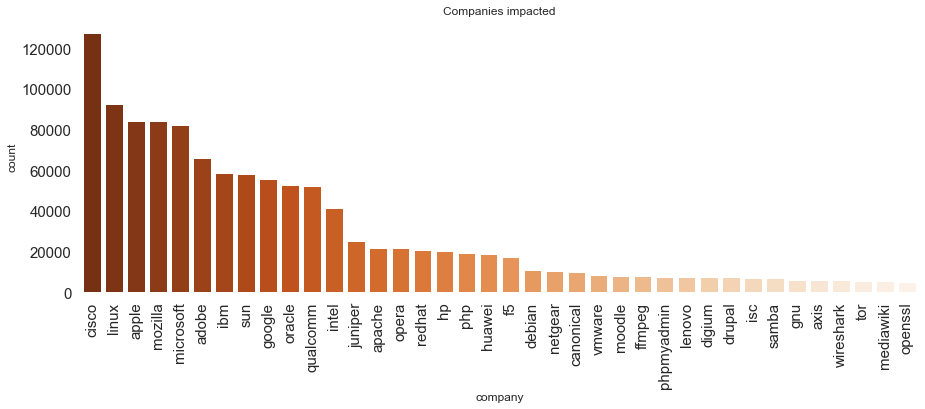

In [401]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="company", y="count", palette="Oranges_r", data=company_count_filtered_gt_n, ci=None);
# plt.yscale('log')
plt.title('Companies impacted')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

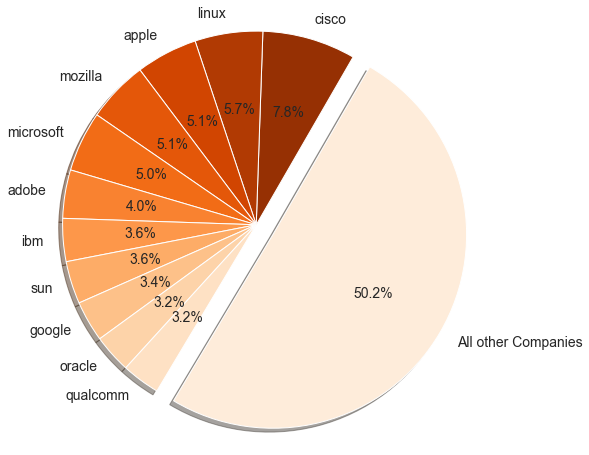

1636445
['cisco', 'linux', 'apple', 'mozilla', 'microsoft', 'adobe', 'ibm', 'sun', 'google', 'oracle', 'qualcomm', 'All other Companies']


In [402]:
less_than_n_cwe = company_count_df[company_count_df['count'] < 50000]['count'].sum()
labels = list(company_count_df[company_count_df['count'] >= 50000]['company'])
labels.append('All other Companies')
sizes = list(company_count_df[company_count_df['count'] >= 50000]['count'])
sizes.append(less_than_n_cwe)
explode = (0,0,0,0,0,0,0,0,0,0,0, 0.1)
# pie_chart_color_list=["#53AAC0", "#53AACC", "#69C5E0", "#8DDBEB", "#D1F5FA"]
# pie_chart_color_list=["#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA","#69C5EE", "#69C5E0", "#8DDBEB",  '#BFBFBD']
# pie_chart_color_list=["#53AACC",'#ffcc99' ,'#66b3ff','#99ff99','#ff9999']

fig1, ax1 = plt.subplots(figsize=(8,8))
# 
# colors=pie_chart_color_list,

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("Oranges_r", 12),
        shadow=True, startangle=60,  textprops={'fontsize': 14}, explode=explode)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print(sum(sizes))
print(labels)

In [403]:
data = {'product':[], 'count':[]}
for key, value in product_counter.items():
    data['product'].append(f'{key}')
    data['count'].append(value)
    
product_count_df = pd.DataFrame(data)
product_count_df.sort_values(by=['count'], ascending=False, inplace=True)
product_count_df.reset_index(drop=True, inplace=True)
product_count_filtered_gt_n = product_count_df[product_count_df['count'] >= 5000]

In [404]:
product_count_filtered_gt_n

,product,count
0,linux_kernel,92410
1,ios,54799
2,chrome,38318
3,firefox,34344
4,jre,28192
5,jdk,23900
6,seamonkey,22808
7,flash_player,21707
8,opera_browser,20975
9,junos,19218


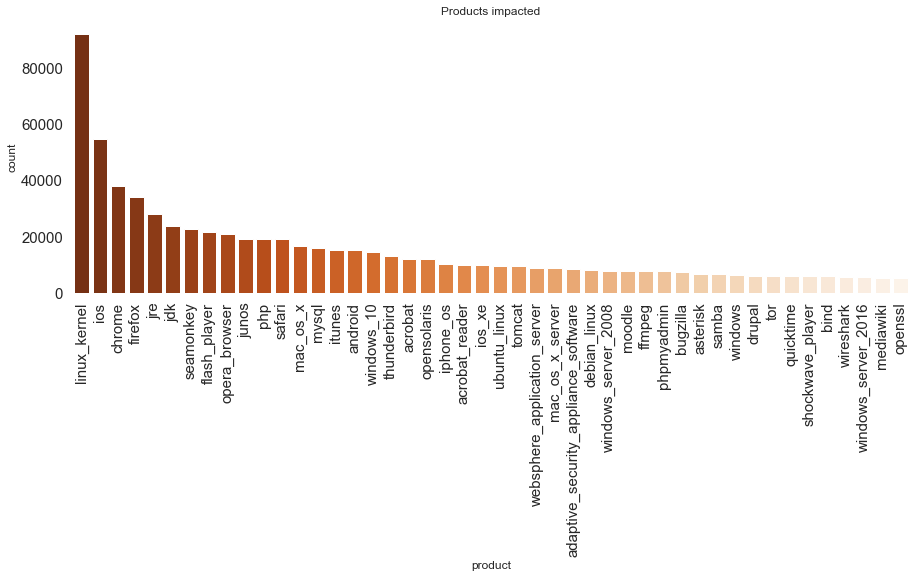

In [405]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="product", y="count", palette="Oranges_r", data=product_count_filtered_gt_n, ci=None);
# plt.yscale('log')
plt.title('Products impacted')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
plt.grid(False)
plt.box(on=None)

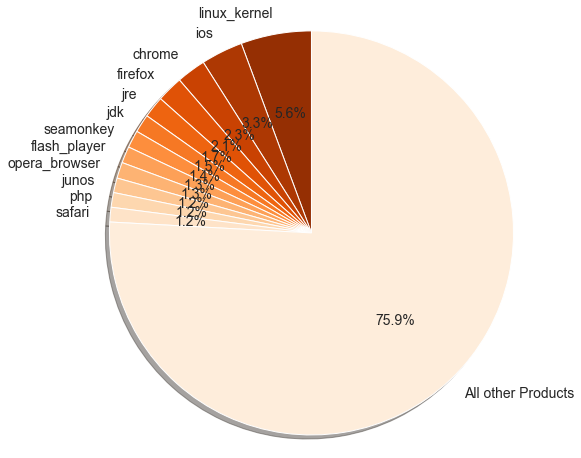

1636445


In [406]:
less_than_n_cwe = product_count_df[product_count_df['count'] < 17000]['count'].sum()
labels = list(product_count_df[product_count_df['count'] >= 17000]['product'])
labels.append('All other Products')
sizes = list(product_count_df[product_count_df['count'] >= 17000]['count'])
sizes.append(less_than_n_cwe)
# explode = (0,0,0,0,0,0,0,0,0,0,0, 0.1)
# pie_chart_color_list=["#53AAC0", "#53AACC", "#69C5E0", "#8DDBEB", "#D1F5FA"]
# pie_chart_color_list=["#69C5EE", "#69C5E0", "#8DDBEB", "#D1F5FA","#69C5EE", "#69C5E0", "#8DDBEB",  '#BFBFBD']
# pie_chart_color_list=["#53AACC",'#ffcc99' ,'#66b3ff','#99ff99','#ff9999']

fig1, ax1 = plt.subplots(figsize=(8,8))
# 
# colors=pie_chart_color_list,

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("Oranges_r",13),
        shadow=True, startangle=90,  textprops={'fontsize': 14}) # explode=explode
ax1.axis('equal')

plt.show()
print(sum(sizes))

In [514]:
most_impacted_comp = ['cisco', 'linux', 'apple', 'mozilla', 'microsoft', 'adobe', 'ibm', 'sun', 'google', 'oracle', 'qualcomm']

data = {'company': [], 
        'CRITICAL': [],
        'HIGH': [],
        'MEDIUM': [],
        'LOW':[],
        'unknown': [],
        'Total_impacts_only': [],
        'Total_all': []}

for comp_name in company_impact_severity:
    if comp_name in most_impacted_comp:
        data['company'].append(comp_name)
        data['unknown'].append(company_impact_severity[comp_name]['unknown'])
        data['CRITICAL'].append(company_impact_severity[comp_name]['CRITICAL'])
        data['HIGH'].append(company_impact_severity[comp_name]['HIGH'])
        data['MEDIUM'].append(company_impact_severity[comp_name]['MEDIUM'])
        data['LOW'].append(company_impact_severity[comp_name]['LOW'])
        s1 = sum([company_impact_severity[comp_name]['LOW'],
                                 company_impact_severity[comp_name]['MEDIUM'],
                                 company_impact_severity[comp_name]['HIGH'],
                                 company_impact_severity[comp_name]['CRITICAL']])
        s2 = company_impact_severity[comp_name]['unknown'] + s1
        data['Total_impacts_only'].append(s1)
        data['Total_all'].append(s2)

In [515]:
company_impact_df = pd.DataFrame(data)

In [517]:
company_impact_df.sort_values(by=['Total_impacts_only'], inplace=True, 
                              ascending=False)
total_impacts_only = company_impact_df['Total_impacts_only']
total_all = company_impact_df['Total_all']

company_impact_df.drop(['Total_impacts_only', 'Total_all'], axis=1, inplace=True)

In [518]:
company_impact_df.set_index('company', drop=True, inplace=True)

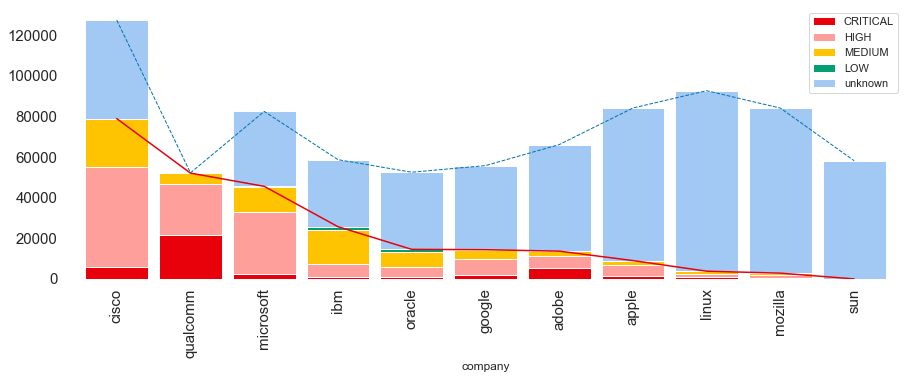

In [535]:
ax = company_impact_df.plot(
    kind='bar', stacked=True,                                                       
    colormap=ListedColormap(
        ['#E8000B',
         '#FF9F9B', 
         '#FFC401', 
         '#059E73',
        '#A2C9F4'
        ]), width=0.85, figsize=(15,5));

ax.plot(company_impact_df.index, total_impacts_only, color='#E8000B', linestyle='-')
ax.plot(company_impact_df.index, total_all, color='#0073B2', linewidth=1, linestyle='--')
plt.grid(False)
plt.box(on=None);

814224


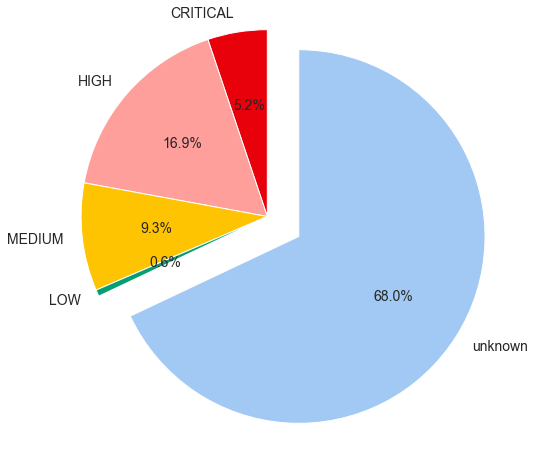

In [540]:
sizes = [company_impact_df['CRITICAL'].sum(),
        company_impact_df['HIGH'].sum(),
        company_impact_df['MEDIUM'].sum(),
        company_impact_df['LOW'].sum(),
        company_impact_df['unknown'].sum()]
labels = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'unknown']
fig1, ax1 = plt.subplots(figsize=(8,8))

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#E8000B',
         '#FF9F9B', 
         '#FFC401', 
         '#059E73',
        '#A2C9F4'
        ],
        explode=(0,0,0,0,0.2),
        shadow=False, startangle=90,  textprops={'fontsize': 14}) # explode=explode
ax1.axis('equal');
print(sum(sizes))

In [528]:
sizes

[42092, 137972, 75962, 4586, 553612]